# Model training
In this notebook a model is created, trained and evaluated on the test set.
<br>MLFlow is used to track the experiments and push a model to production.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import mlflow

from countryguess.data import Dataset, TestDataset
from countryguess.model import CustomEmbeddingModel, EfficientNetEmbedding, TripletModel
from countryguess.generate import TripletDataset, ValDataset
from countryguess.training import train, evaluate

## Plotting datasets

### Initialise datasets

In [2]:
shape=(160, 160)
ref_data = Dataset(shape=shape)
train_data = TripletDataset(shape=shape, temp=0.9)
val_data = ValDataset(shape=shape, temp=0.9)
test_data = TestDataset(shape=shape)

### Plotting

#### Training data

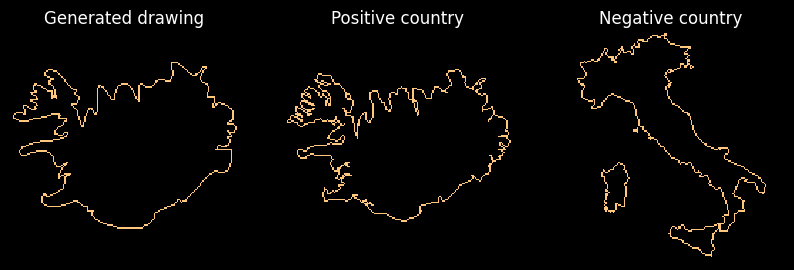

In [3]:
idx = random.randint(0, len(train_data) - 1)
sample = train_data[idx]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
fig.patch.set_facecolor("black")
axs[0].imshow(sample["drawing"], interpolation="nearest", origin="lower", cmap="copper")
axs[0].set_title("Generated drawing", color="white")
axs[1].imshow(sample["pos_img"], interpolation="nearest", origin="lower", cmap="copper")
axs[1].set_title("Positive country", color="white")
axs[2].imshow(sample["neg_img"], interpolation="nearest", origin="lower", cmap="copper")
axs[2].set_title("Negative country", color="white")
for ax in axs:
    ax.axis("off")
plt.show()

#### Validation set

In [4]:
from countryguess.data import poly_to_img

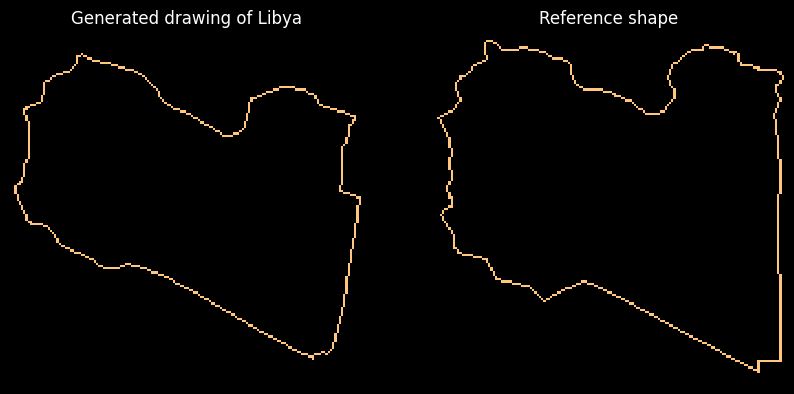

In [5]:
idx = random.randint(0, len(val_data) - 1)
sample = val_data[idx]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.patch.set_facecolor("black")
axs[0].imshow(sample["drawing"], interpolation="nearest", origin="lower", cmap="copper")
axs[0].set_title(f"Generated drawing of {sample['country_name']}", color="white")

img = poly_to_img(ref_data.from_country_name(sample["country_name"]), ref_data.shape)
axs[1].imshow(img, interpolation="nearest", origin="lower", cmap="copper")
axs[1].set_title("Reference shape", color="white")
for ax in axs:
    ax.axis("off")
plt.show()

#### Test set (user drawings)

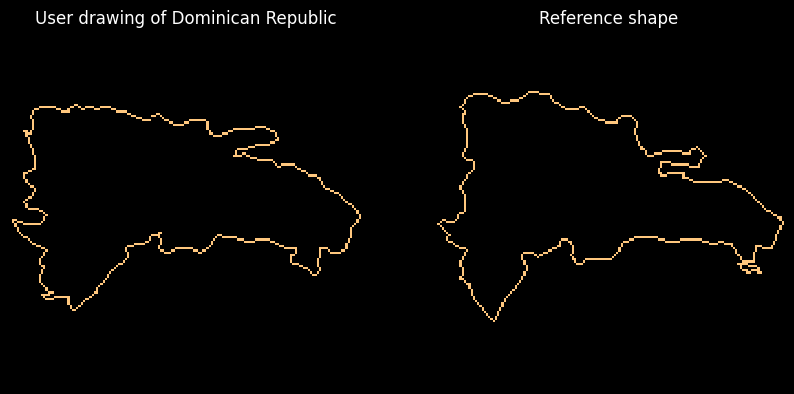

In [6]:
idx = random.randint(0, len(test_data) - 1)
sample = test_data[idx]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.patch.set_facecolor("black")
axs[0].imshow(sample["drawing"], interpolation="nearest", origin="lower", cmap="copper")
axs[0].set_title(f"User drawing of {sample['country_name']}", color="white")

img = poly_to_img(ref_data.from_country_name(sample["country_name"]), ref_data.shape)
axs[1].imshow(img, interpolation="nearest", origin="lower", cmap="copper")
axs[1].set_title("Reference shape", color="white")
for ax in axs:
    ax.axis("off")
plt.show()

## Training model

Run the following command to start the MLFlow Tracking UI: `mlflow ui --port 5001`
<br>Access the MLFlow Tracking UI at: http://127.0.0.1:5001

In [7]:
device = torch.device("mps")

In [8]:
mlflow.set_experiment("local")

params = {
    "channels": 12, #4 * random.randint(2, 6),
    "nr_conv_blocks": 4, #random.randint(2, 5),
    "embedding_size": 768, #128 * random.randint(1, 8),
    "shape": 96, #32 * random.randint(1, 4),
    # "pretrained": True,
    "learning_rate": random.uniform(0.006, 0.012),
    "margin": 1, #random.uniform(0.1, 1.2),
    "temperature": 0.6, #random.uniform(0.4, 1.1),
    "nr_epochs": 56, #random.randint(15, 75),
}

model = TripletModel(CustomEmbeddingModel(**params).to(device)).to(device)
# model = TripletModel(EfficientNetEmbedding(**params).to(device)).to(device)
params["embedding_model"] = model.embedding_model.__class__.__name__

optimizer = torch.optim.SGD(model.parameters(), lr=params["learning_rate"])
triplet_loss = nn.TripletMarginLoss(margin=params["margin"])

print(params)

{'channels': 12, 'nr_conv_blocks': 4, 'embedding_size': 768, 'shape': 96, 'learning_rate': 0.009131981574954928, 'margin': 1, 'temperature': 0.6, 'nr_epochs': 56, 'embedding_model': 'CustomEmbeddingModel'}


In [9]:
#Initialise datasets & dataloaders
ref_data = Dataset(shape=(params["shape"], params["shape"]))
train_data = TripletDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])
val_data = ValDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])

train_dl = DataLoader(train_data, batch_size=24, shuffle=True, num_workers=2)
val_dl = DataLoader(val_data, batch_size=24, num_workers=2)

In [10]:
with mlflow.start_run() as run:
    mlflow.log_params(params)

    # Start training
    for epoch in range(params["nr_epochs"]):
        loss = train(model, train_dl, triplet_loss, optimizer)
        mlflow.log_metric("loss", loss, epoch)
        print(
            "Epoch: {}/{}\t loss: {:.3f}".format(epoch + 1, params["nr_epochs"], loss)
        )

        if (epoch + 1) % 5 == 0:
            _, ranking = evaluate(model, val_dl, ref_data)

            mlflow.log_metric("val_avg_rank", np.mean(ranking) + 1, epoch)
            mlflow.log_metric("val_top_10_acc", np.mean(ranking < 10), epoch)
            mlflow.log_metric("val_top_1_acc", np.mean(ranking < 1), epoch)

            print(
                "Epoch: {}/{}\t Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t".format(
                    epoch + 1,
                    params["nr_epochs"],
                    np.mean(ranking) + 1,
                    100 * np.mean(ranking < 10),
                    100 * np.mean(ranking < 1),
                )
            )

Epoch: 1/56	 loss: 1.514


Epoch: 2/56	 loss: 1.470


Epoch: 3/56	 loss: 1.428


Epoch: 4/56	 loss: 1.482


Epoch: 5/56	 loss: 1.413


Epoch: 5/56	 Average rank: 4.63	 top 10 acc: 96.4%	 top 1 acc: 91.9%	


Epoch: 6/56	 loss: 1.439


Epoch: 7/56	 loss: 1.465


Epoch: 8/56	 loss: 1.511


Epoch: 9/56	 loss: 1.405


Epoch: 10/56	 loss: 1.451


Epoch: 10/56	 Average rank: 4.24	 top 10 acc: 94.4%	 top 1 acc: 85.3%	


Epoch: 11/56	 loss: 1.349


Epoch: 12/56	 loss: 1.344


Epoch: 13/56	 loss: 1.394


Epoch: 14/56	 loss: 1.387


Epoch: 15/56	 loss: 1.271


Epoch: 15/56	 Average rank: 3.68	 top 10 acc: 95.9%	 top 1 acc: 88.3%	


Epoch: 16/56	 loss: 1.335


Epoch: 17/56	 loss: 1.268


Epoch: 18/56	 loss: 1.209


Epoch: 19/56	 loss: 1.211


Epoch: 20/56	 loss: 1.204


Epoch: 20/56	 Average rank: 2.38	 top 10 acc: 96.4%	 top 1 acc: 87.8%	


Epoch: 21/56	 loss: 1.131


Epoch: 22/56	 loss: 1.259


Epoch: 23/56	 loss: 1.225


Epoch: 24/56	 loss: 1.266


Epoch: 25/56	 loss: 1.259


Epoch: 25/56	 Average rank: 4.35	 top 10 acc: 96.4%	 top 1 acc: 84.3%	


Epoch: 26/56	 loss: 1.266


Epoch: 27/56	 loss: 1.200


Epoch: 28/56	 loss: 1.240


Epoch: 29/56	 loss: 1.144


Epoch: 30/56	 loss: 1.156


Epoch: 30/56	 Average rank: 2.89	 top 10 acc: 95.9%	 top 1 acc: 85.8%	


Epoch: 31/56	 loss: 1.148


Epoch: 32/56	 loss: 1.162


Epoch: 33/56	 loss: 1.103


Epoch: 34/56	 loss: 1.072


Epoch: 35/56	 loss: 1.090


Epoch: 35/56	 Average rank: 2.43	 top 10 acc: 96.4%	 top 1 acc: 83.2%	


Epoch: 36/56	 loss: 1.091


Epoch: 37/56	 loss: 1.065


Epoch: 38/56	 loss: 1.109


Epoch: 39/56	 loss: 1.082


Epoch: 40/56	 loss: 0.987


Epoch: 40/56	 Average rank: 2.82	 top 10 acc: 94.9%	 top 1 acc: 85.3%	


Epoch: 41/56	 loss: 1.141


Epoch: 42/56	 loss: 1.013


Epoch: 43/56	 loss: 1.077


Epoch: 44/56	 loss: 1.075


Epoch: 45/56	 loss: 1.103


Epoch: 45/56	 Average rank: 3.68	 top 10 acc: 95.4%	 top 1 acc: 87.3%	


Epoch: 46/56	 loss: 1.001


Epoch: 47/56	 loss: 1.164


Epoch: 48/56	 loss: 1.020


Epoch: 49/56	 loss: 1.131


Epoch: 50/56	 loss: 1.103


Epoch: 50/56	 Average rank: 2.74	 top 10 acc: 97.5%	 top 1 acc: 83.8%	


Epoch: 51/56	 loss: 1.039


Epoch: 52/56	 loss: 0.954


Epoch: 53/56	 loss: 0.997


Epoch: 54/56	 loss: 0.980


Epoch: 55/56	 loss: 0.857


Epoch: 55/56	 Average rank: 2.58	 top 10 acc: 95.9%	 top 1 acc: 84.3%	


Epoch: 56/56	 loss: 1.066


### Evaluate model

In [11]:
test_data = TestDataset(shape=(params["shape"], params["shape"]))
test_dl = DataLoader(test_data, batch_size=32)

In [12]:
country_names, ranking = evaluate(model, test_dl, ref_data)

with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_metric("nr_test_samples", len(test_data))
    mlflow.log_metric("test_avg_rank", np.mean(ranking) + 1)
    mlflow.log_metric("test_top_10_acc", np.mean(ranking < 10))
    mlflow.log_metric("test_top_1_acc", np.mean(ranking < 1))

In [13]:
print("Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t"
      .format(np.mean(ranking) + 1, 100 * np.mean(ranking < 10), 100 * np.mean(ranking < 1)))

Average rank: 86.78	 top 10 acc: 28.3%	 top 1 acc: 10.9%	


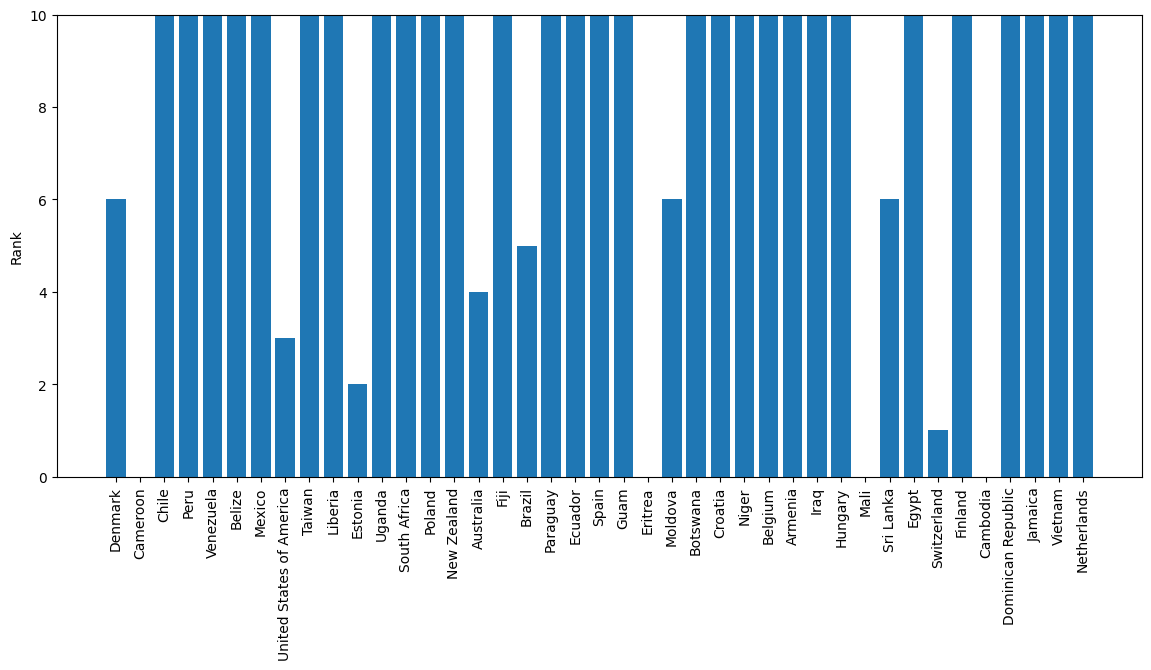

In [14]:
fig = plt.figure(figsize = (14, 6))
plt.bar(country_names, ranking)
plt.xticks(rotation=90)
plt.ylim((0, 10))
plt.ylabel("Rank")
plt.show()

### Log model

In [ ]:
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.pytorch.log_model(model, "model")

Make sure to set promote your desired model to the Model Registry using the MLFlow UI. The model with the champion alias will be used by the ML server.  You can set the name of the model within the docker-compose.yml file or by setting the environment variable MODEL_NAME if you run the app locally.

### Error Analysis
Let's look at the countries for which the model struggles. 

In [ ]:
print("Rank\tCountry")
for country, rank, in zip(country_names, ranking):
    if rank > 0:
        print(f"{int(rank+1)}\t{country}")